# Calibration

Modern integrated circuits, or chips, are manufactured using a complex process where the chips are essentially printed onto a silicon wafer (see this **[video](https://www.youtube.com/watch?v=g8Qav3vIv9s)** for an overview of the process). Each wafer contains many chips (e.g. a wafer with 300mm diameter fits several hundred laptop grade microprocessors). The chips on a finished wafer are tested to identify which are good and which are faulty. The yield of a wafer is determined by the fraction of good chips. To maximize the yield, semiconductor manufacturers are interested in identifying and correcting the causes of the faulty chips (e.g. wrong settings in one of processing steps). Some causes can be identified by visual inspection of patterns in a wafer maps, showing which chips are good and which are faulty.

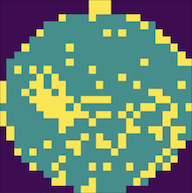

In this assignment you will work with wafer map data from a semiconductor manufacturing process. Your task will be to develop a calibrated classifier for identifying patterns of faulty chips on a finished wafer. Identifying such patterns can help with optimizing the manufacturing process parameters for the following wafers.

#### Deliverable

Throughout this notebook you will find cells starting with `#TODO` and `# // BEGIN_TODO`.

- Fill in all these TODO cells. The `#TODO` cells are meant to guide you (you are strongly encouraged to fill these in!), while the `#BEGIN_TODO` _answer cells_ will be graded.
- Answer cells start and end with tags, `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]`, for example. Do not edit these tags in any way, or else your answers may not be processed by the grading system.
- Be careful when importing additional libraries. The code for of your answers will be evaluated automatically and we cannot guarantee that any additional libraries will be available in that environment. Please check the Momotor output on Canvas after submitting the assignment, you should be able to see if all your code executed without errors. If in doubt, please ask your instructor.
- You can add arbitrary many code and text cells between the `# // BEGIN_TODO` and `# // END_TODO` tags to make your code nicely readable.

You are encouraged to play with the data and extend this notebook in order to obtain your answers. You may insert cells at any point in the notebook, but remember:
<br/><br/>
<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Only the code in your answer cells (i.e. between `# // BEGIN_TODO` and `# // END_TODO`) will be extracted and evaluated.
</div>

At the end, deliver the filled in **and executed** `.ipynb` file by submitting it to the corresponding assignment on Canvas. You may submit as many times as you like before the deadline. The last submission counts.

> **IMPORTANT:** Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu.

Let's get started by filling in your details in the following answer cell. Assign your group number, your names and student ids to variables `group_number`, `name_student1`, `id_student1`, `name_student2`, `id_student2`, e.g.:

```
# // BEGIN_TODO [AUTHOR]
group_number = "7"
name_student1 = "John Smith"
id_student1 = "1234567"
name_student2 = "Jane Miller"
id_student2 = "7654321"
# // END_TODO [AUTHOR]
```

In [1]:
#// BEGIN_TODO [AUTHOR]
group_number = "2"
name_student1 = "Tobias Sagis"
id_student1 = "1333151"
name_student2 = "Ivan Horn"
id_student2 = "0807338"
#// END_TODO [AUTHOR]

## Import libraries

Later, the code in your answer cells will be evaluated in an environment with several typical data science libraries installed, including pandas, numpy, matplotlib, sklearn. You are free to use them. If you would like to use other libraries, please contact the instructor to see if it can be accommodated. Please import any additional libraries inside your answer cells (otherwise your code may crash during evaluation).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Sklearn libraries
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn import calibration

## Load the data

The data resides in the `./data/wafer_calibration.pkl` pickle file. It is based on the WM-811K dataset containing annotated wafer maps collected from real-world fabrication (see `./data/readme.txt`).

In [3]:
with open('./data/wafer.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

`X` contains wafer maps and `y` contains the labels. The maps are 26x26 pixels, a pixel of value 0 represents the background, a pixel of value 1 indicates a good chip, and a pixel of value 2 indicates a bad chip. An example of a wafer map is shown below.

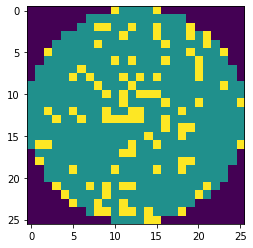

In [4]:
plt.imshow(X_train[0]);

The wafer maps were labeled by human experts according to bad chip patterns, where each label is an integer:

- 0: No pattern
- 1: Center
- 2: Donut
- 3: Edge-local
- 4: Edge-ring
- 5: Local
- 6: Near-full
- 7: Random
- 8: Scratch

An example of the wafer map for each pattern is shown below. Note that not all patterns may be present in this particular data set. 

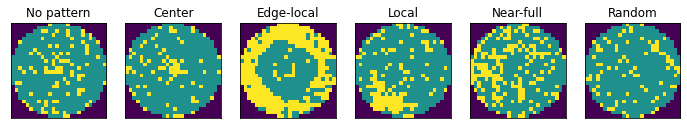

In [5]:
unique_classes, class_indexes = np.unique(y_train,return_index=True)
class_names = ["No pattern", "Center", "Donut", "Edge-local", "Edge-ring", "Local", "Near-full", "Random", "Scratch"]
fig, axes = plt.subplots(1,len(unique_classes), figsize = (12,5))
for num_index, index in enumerate(class_indexes):
    axes[num_index].imshow(X_train[index])
    axes[num_index].set_title(class_names[unique_classes[num_index]])
    axes[num_index].set_xticks([])
    axes[num_index].set_yticks([])

## Train a classifier

In this part you will implement a classifier, which will be used later for evaluating your calibration method.

First, start by exploring the data. Remember, you can add as many code and markdown cells as you like.

In [6]:
# TODO: Explore the data
print(X_train.shape)
print(y_train.shape)

(4310, 26, 26)
(4310,)


In the first part of this assignment the aim is to identify whether the wafer map contains any known patterns or not. We therefore treat it as a binary classification problem and replace labels other than 0 to 1.

In [7]:
y_binary_train = np.copy(y_train)
y_binary_train[y_binary_train != 0] = 1

y_binary_test = np.copy(y_test)
y_binary_test[y_binary_test != 0] = 1

#### Step 1

Choose a metric for evaluating the classifier's generalization performance and assign your choice to a string variable `classifier_metric_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `classifier_metric_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `classifier_metric_decision` (max 200 characters).

In [8]:
#// BEGIN_TODO [STEP_1] Choose a classifier metric (5 points)

classifier_metric_choice = "Recall"

classifier_metric_motivation = """
    We initially wanted to use the Precision metric, due to the fact that the dataset imbalance is already leaning towards
    negative classifications. However, under the assumption that false negative predictions are very costly for the company,
    we will use the Recall metric to minimize the amount of false negative predictions. This assumption considers the fact that
    if a wafer is flagged as 'non-pattern', but still turns out to have a pattern, then it is essentially delivered in a
    defect state. False positive predictions are less of an issue since we assume that the cost of checking if such a prediction
    is correct, outweights the risk(and cost) of sending a defect wafer to the customer.
    """

classifier_metric_decision = """
    If Recall is high the model has a low rate of selecting false negatives. 
    Higher Recall score essentially tells us that the model behaves correctly, by avoiding flagging defect wafers 
    as non-defect.
    """


classifier_metric_choice = "Precision"

classifier_metric_motivation = """ 
    For imbalanced data sets, we have the following metrics to consider; Recall, Precision and F1(F-measure).
    We think Precision is a good metric to use, because this metric essentially focusses on minimizing false positives.
    Minimizing false negatives is not necessarily important in this dataset due to the imbalance leaning towards a
    'negative classification' already. Thus we assume that the Recall evaluation metric, which is primarily focussed on
    minimizing false negatives, is not very useful for us in this scenario. 
    We also consider F1-score (F-measure) as a metric for our classification, since this metric considers minimizing both
    false negatives as well as false positives. We are convinced that Precision would give us better results due to the 
    structure of imbalance.
    """

classifier_metric_decision = """
    If Precision is high, then the chance of finding a false positive is very low. In this scenario we are primarily 
    interested in finding patterns, and we want to minimize the chance of flagging a wafer as '' """


In [9]:
#// END_TODO [STEP_1]

#### Step 2

Train a binary classifier on the training set `X_train` and `y_train`. You are free to chose any model and data preprocessing method, as long as:

- your classifier outputs the predicted class (0 or 1) and the confidence estimate of the positive class,
- your submission executes within 10 minutes on Momotor,
- you use the libraries available on Momotor (if you would like to use other libraries, please contact the instructor to see if it can be accommodated).

Evaluate your trained model on the test set `X_test` and `y_test`. What do you observe? How do you know that your model is well trained? Assign your answer to a string variable `observation_classifier` (max 600 characters).

Apply the classifier to the `X_test` data and store the predicted classes and confidence estimate in the variables `uncalibrated_y` and `uncalibrated_p`, respectively:

- `uncalibrated_y` should be a `np.ndarray` of shape $[N,]$ and `dtype` of `np.int32`, where $N$ is the number of samples and each value is the predicted class,
- `uncalibrated_p` should be a `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`, where each value is the classifier's confidence in the positive class.

In [10]:
#// BEGIN_TODO [STEP_2] Train a binary classifier (10 points)

In [11]:
# Preprocessing - Convert 26x26 pattern to a 1D feature vector of size 676
feature_vectors_train = X_train.reshape(len(X_train), -1) # (4310, 676)
feature_vectors_test = X_test.reshape(len(X_test), -1) # (1990, 676)

# Preprocessing - Standardization for our machine learning estimator
scaler = preprocessing.StandardScaler()
x_binary_train = scaler.fit_transform(feature_vectors_train)
x_binary_test = scaler.fit_transform(feature_vectors_test)

In [48]:
# Training - Fitting data to a SVC classifier
classifier = svm.SVC(gamma='auto', class_weight='balanced')
classifier.fit(x_binary_train, y_binary_train)

SVC(class_weight='balanced', gamma='auto')

In [49]:
# Scoring - Calculate the precision of the classifier
y_binary_train_predictions = classifier.predict(x_binary_train)

weighted_recall = metrics.recall_score(y_binary_train, y_binary_train_predictions, average='weighted')
non_pattern_recall = metrics.recall_score(y_binary_train, y_binary_train_predictions, average='binary', pos_label=0)
pattern_recall = metrics.recall_score(y_binary_train, y_binary_train_predictions, average='binary', pos_label=1)

print("Confidence estimation of the classifier using Recall. (train set)\n" + 
      "Non-pattern class confidence: " + str(non_pattern_recall) + "\n"
      "Pattern class confidence: " + str(pattern_recall) + "\n"
      "Average (weighted) confidence: " + str(weighted_recall))

Confidence estimation of the classifier using Recall. (train set)
Non-pattern class confidence: 0.9979376127868007
Pattern class confidence: 1.0
Average (weighted) confidence: 0.9981438515081207


In [50]:
# Scoring - Calculate the precision of the classifier on the test set
y_binary_test_predictions = classifier.predict(x_binary_test)

weighted_recall = metrics.recall_score(y_binary_test, y_binary_test_predictions, average='weighted')
non_pattern_recall = metrics.recall_score(y_binary_test, y_binary_test_predictions, average='binary', pos_label=0)
pattern_recall = metrics.recall_score(y_binary_test, y_binary_test_predictions, average='binary', pos_label=1)

print("Confidence estimation of the classifier using Recall. (test set)\n" + 
      "Non-pattern class confidence: " + str(non_pattern_recall) + "\n"
      "Pattern class confidence: " + str(pattern_recall) + "\n"
      "Average (weighted) confidence: " + str(weighted_recall))

Confidence estimation of the classifier using Recall. (test set)
Non-pattern class confidence: 0.9793526785714286
Pattern class confidence: 0.5202020202020202
Average (weighted) confidence: 0.9336683417085427


In [51]:
# Scoring - Prediction confidence estimates
y_binary_test_pred_estimates = classifier.decision_function(x_binary_test)

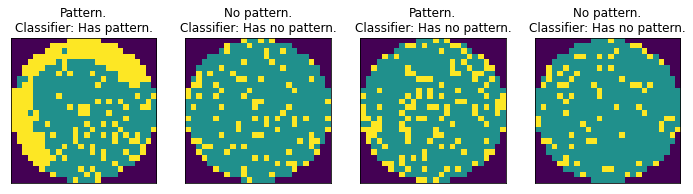

In [52]:
# Predictions - A quick inspection of the performance of the model
nr_samples = 4
no_pattern_indexes = np.array(np.where(y_binary_test == 0)).flatten()
pattern_indexes = np.array(np.where(y_binary_test == 1)).flatten()
fig, axes = plt.subplots(1, nr_samples, figsize = (12,5))
for index in range(nr_samples):
    if index % 2 != 1:
        sample_pattern_index = np.random.choice(pattern_indexes)
        ax_title = "Pattern.\n"
    else:
        sample_pattern_index = np.random.choice(no_pattern_indexes)
        ax_title = "No pattern.\n"

    sample_pattern_img = X_test[sample_pattern_index]
    sample_feature_vector = x_binary_test[sample_pattern_index].reshape(1, -1)
    prediction = classifier.predict(sample_feature_vector)
    
    if (prediction == 1):
        classifier_result = "Classifier: Has pattern."
    else:
        classifier_result = "Classifier: Has no pattern."
        
    axes[index].imshow(sample_pattern_img)
    axes[index].set_title(ax_title + classifier_result)
    axes[index].set_xticks([])
    axes[index].set_yticks([])

In [53]:
# Evaluate - Evaluate and store results in appropriate variables

observation_classifier = """
    We observer several things. First the confidence of the classifier, which we measure using Recall, is very high for the
    non-pattern class, and reasonably high for the pattern set. These are great results for the few samples that we have,
    however calibration is needed to improve these results. Furthermore, we also observe that this performance is reflected
    in the arbitrary samples above. The weighted Recall is very high on both the train and test data, which means that the 
    model is well trained, and remains to be calibrated to improve the individual class results.
    """

uncalibrated_y = np.array(y_binary_test_predictions, dtype=np.int32)
uncalibrated_p = np.array(y_binary_test_pred_estimates, dtype=np.float32)
#print(np.info(uncalibrated_y))
#print(np.info(uncalibrated_p)) 

In [54]:
#// END_TODO [STEP_2]

## Measure and visualize calibration

#### Step 3

Visualize the calibration of your trained model using a reliability diagram. Describe your observations in the variable `observation_uncalibrated` (max 1000 characters).

In [55]:
#// BEGIN_TODO [STEP_3] Visualize calibration of uncalibrated model (5 points)

C:\Users\Tobias\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


Text(0.5, 1.0, 'Calibration curve - Equal mass bins')

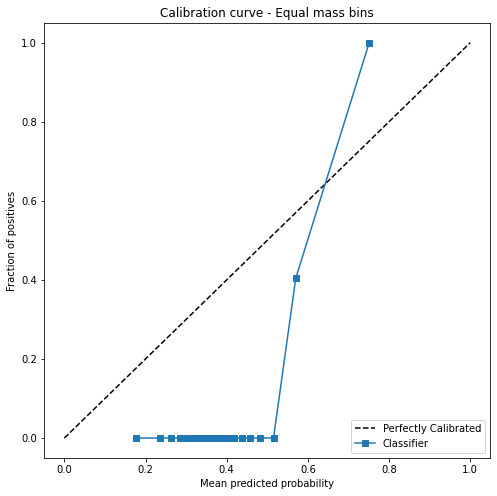

In [56]:
# Calibration - Visualize the calibration curve using Equal-mass bins
bin_probability_mean, empirical_probability = \
    calibration.calibration_curve(uncalibrated_y, uncalibrated_p, n_bins=20, normalize=True, strategy='quantile')


plt.figure(figsize=(8, 8))
plt.plot([0,1], [0,1], linestyle='--', color='k', label='Perfectly Calibrated')
plt.plot(empirical_probability, bin_probability_mean, marker='s', label='Classifier')
plt.legend(loc='lower right')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title("Calibration curve - Equal mass bins")

Text(0.5, 1.0, 'Calibration curve - Equal width bins')

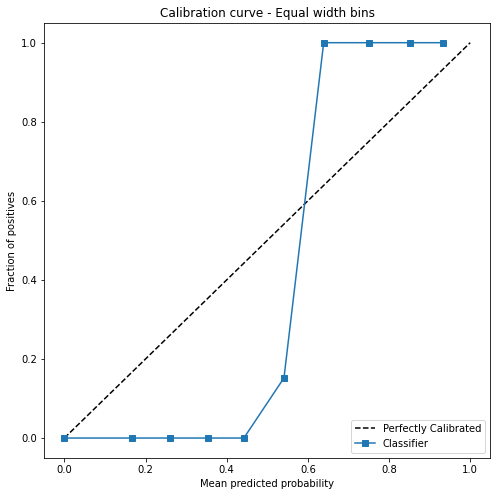

In [57]:
# Calibration - Visualize the calibration curve using 
bin_probability_mean, empirical_probability = \
    calibration.calibration_curve(uncalibrated_y, uncalibrated_p, n_bins=10, normalize=True)


plt.figure(figsize=(8, 8))
plt.plot([0,1], [0,1], linestyle='--', color='k', label='Perfectly Calibrated')
plt.plot(empirical_probability, bin_probability_mean, marker='s', label='Classifier')
plt.legend(loc='lower right')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title("Calibration curve - Equal width bins")

In [58]:
observation_uncalibrated = """
    We first observe the problem with equal-width binning. That is, as most bins approximate the same fraction of positives
    value, only 2-3 bins in the graph actually contribute to the calibration error. In both plots we also observe the 's' curve
    that forms. In our case, this means that the classifier overestimates low(<=0.2) probabilities, resulting in a high
    probability prediction when in fact, this is not the case. Conversely the classifier also underestimates almost all samples
    from 0.6 as positive. The equal-mass bin graph shows that overestimation is actually a big problem, as almost all small
    bins reside in the overestimation area.
    """

In [59]:
#// END_TODO [STEP_3]

#### Step 4

Choose a calibration metric and assign its name to a string variable `binary_metric_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `binary_metric_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `binary_metric_decision` (max 200 characters).

In [61]:
#// BEGIN_TODO [STEP_4] Choose a calibration metric (5 points)

binary_metric_choice = "Expected Calibration Error (ECE)"

binary_metric_motivation = """
    
    """

binary_metric_decision = """
    
    """

print(bin_probability_mean)
print(empirical_probability)

[0.         0.         0.         0.         0.         0.15204678
 1.         1.         1.         1.        ]
[0.         0.16709145 0.26091585 0.35415843 0.44232779 0.54114519
 0.63897011 0.75052874 0.85279525 0.93303724]


In [ ]:
#// END_TODO [STEP_4]

#### Step 5

Implement the chosen calibration metric. It should be a Python class with the following method:

- `score(self, p, y)`, where
    - `p` is an `np.ndarray` of shape $[N,]$ with the confidence estimates of the *positive class* for $N$ samples.
    - `y` is an `np.ndarray` of shape $[N,]$ with the corresponding true labels (0 or 1).
    - It returns a `np.float` number with the calibration error.

Instantiate the class (setting any relevant hyper-parameters) and assign it to the variable `binary_metric`.

Measure the calibration error of your model on `X_test` and `y_test` and assign the result to the variable `binary_uncalibrated`.

In [ ]:
#// BEGIN_TODO [STEP_5] Implement the calibration metric (5 points)

In [94]:
# Class definition
class cal_metric:
    def __init__(self, nr_bins, binning_scheme):
        self.nr_bins = nr_bins
        self.binning_scheme = binning_scheme
    
    def score(self, p, y):
        # Normalize prediction scores to [0,1]
        p = (p - p.min()) / (p.max() - p.min())
        
        # Define bins according to given scheme
        if (self.binning_scheme == "equal_width"):
            bins = np.linspace(0, 1, self.nr_bins + 1)
        elif (self.binning_scheme == "equal_mass"):
            bins = np.linspace(0, 1, self.nr_bins + 1)
            bins = np.percentile(p, bins*100)
        else:
            raise('Binning scheme not supported.')
            
        # Neglect bins 0 and 1
        actual_bins = bins[1:-1]
        
        # Assign probabilities to corresponding bins
        bin_indexes = np.searchsorted(actual_bins, p)
        
        # Work out bin statistics
        y_sum = np.bincount(bin_indexes, weights=y, minlength=len(bins))
        p_sum = np.bincount(bin_indexes, weights=p, minlength=len(bins))
        total_bin_sum = np.bincount(bin_indexes, minlength=len(bins))
        nonzero_bins = total_bin_sum != 0
        mean_predicted_probability = p_sum[nonzero_bins] / total_bin_sum[nonzero_bins]
        fraction_of_positives = y_sum[nonzero_bins] / total_bin_sum[nonzero_bins]
        
        # Calculate ECE
        ece = np.sum((total_bin_sum[nonzero_bins] / len(y))*abs(fraction_of_positives - mean_predicted_probability))
        
        return ece

In [102]:
# Measure the calibration error
binary_metric = cal_metric(20, "equal_mass")
binary_uncalibrated = binary_metric.score(uncalibrated_p, uncalibrated_y)
print(binary_uncalibrated)

0.3445330750066132


In [ ]:
#// END_TODO [STEP_5]

## Calibrate the classifer

#### Step 6

Implement at least two calibration methods. Each calibration method should be a Python class with the following methods:

- `fit(self, p, y)`, where 
    - `p` is an `np.ndarray` of shape $[N,]$ with the confidence estimates of the *positive class* for $N$ samples.
    - `y` is an `np.ndarray` of shape $[N,]$ with the corresponding true labels (0 or 1).
    - It fits the calibration model and returns a reference to `self`.
- `predict_proba(self, p)`, where
    - `p` is an `np.ndarray` of shape $[N,]$ with confidence estimates of the *positive class* for $N$ samples.
    - It returns an `np.ndarray` of shape $[N,]$ with the calibrated confidence estimates for each sample in `p`.

> **IMPORTANT:** You are not allowed to use the `sklearn.calibration.CalibratedClassifierCV()` method.

Instantiate the calibration methods (setting any relevant hyper-parameters) and assign them to a list variable `binary_calibrators`.

In [ ]:
#// BEGIN_TODO [STEP_6] Implement calibration methods (10 points)

In [ ]:
# Class definition
class cal_model:
    def __init__(self):
        
    def fit(self, p, y):
        return self
    
# Platt scaling is good

In [ ]:
# Class definition
class cal_confidence_estimates:
    def __init__(self):
        
    def predict_proba(self, p):
        

In [ ]:
#// END_TODO [STEP_6]

#### Step 7

Evaluate the performance of your calibration methods. Describe your observations in the variable `observation_calibrators` (max 2000 characters).

In [ ]:
#// BEGIN_TODO [STEP_7] Evaluate the calibration method (10 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_7]

#### Step 8

Let's evaluate your selected calibration method on the output from different classifier, stored in the `./data/wafer_calibration.pkl` pickle file.

In [ ]:
with open('./data/wafer_calibration.pkl', 'rb') as f:
    p_calib_train, p_calib_test, y_calib_train, y_calib_test = pickle.load(f)

`p_calib_train` and `p_calib_test` contain the confidence estimates of a classifier (divided into a training and test set), and `y_calib_train` and `y_calib_test` contain the corresponding true labels.

Retrain your calibration methods on `p_calib_train` and `y_calib_train`. Use `p_calib_test` and `y_calib_test` to evaluate your methods. Describe your observations in the variable `observation_other` (max 800 characters).

In [ ]:
#// BEGIN_TODO [STEP_8] Evaluate the calibration method on another classifier (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_8]

#### Step 9

Choose your favorite calibration method. Assign the instantiated class implementing your chosen calibration method to the variable `binary_calibrator` and its name to a string variable `binary_calibrator_choice`. Motivate the choice (including hyper-parameters, if any) in a string variable `binary_calibrator_motivation` (max 800 characters).

Apply the chosen calibration method to your model on the test data `X_test` and assign the calibrated confidence estimates to `q_test` (an `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`).

Apply the calibration method to the confidence estimates in `p_calib_test` and assign the calibrated class probabilities to the variable `q_calib_test` (an `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`).

Measure the calibration error of the calibrated model and assign the result to the variable `binary_calibrated`.

In [ ]:
#// BEGIN_TODO [STEP_9] Choose a calibration method (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_9]

#### Leaderboard

If you would like to see how your binary calibration method compares to others, you can chose to submit your calibration method to the leaderboard. All submitted calibration methods will be evaluated on a held-out set from a similar distribution as `p_calib_test` and `y_calib_test`.

You may submit your notebook as many times as you like before the deadline. We will try to update the leaderboard daily. Your latest submission at the moment the leaderboard is computed will count. 

If you would like to submit your `binary_calibrator` to the leaderboard, then assign a reference to your *trained* calibration method to the variable `leaderboard_calibrator`. Otherwise, set it to `None`. Since it will be evaluated on a held-out set, you are free to use any data that was included with this assignment. Also, assign a nickname to the string variable `leaderboard_nickname` that will be shown on the leaderboard next to your score.

In [ ]:
#// BEGIN_TODO [LEADERBOARD] Join the leaderboard (0 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [LEADERBOARD]

## Extend to multi-class classification

So far we have assumed a binary classification task. In this part you will implement a calibration metric and method that is applicable to multi-class classification.

#### Step 10

For evaluating the multi-class calibration metric and method, train a classifier on the multi-class wafer map data `X_train` and `y_train` that was loaded earlier. You are free to chose any model and data preprocessing method, as long as:

- your classifier outputs the predicted class and the confidence estimate for each class,
- your submission executes within 10 minutes on Momotor,
- you use the libraries available on Momotor (if you would like to use other libraries, please contact the instructor to see if it can be accommodated).

Evaluate your trained model on the test set `X_test` and `y_test`. What do you observe? How do you know that your model is well trained? Assign your answer to a string variable `observation_multiclass_classifier` (max 600 characters).

Apply the classifier to the `X_test` data and store the predicted classes and confidence estimates in the variables `multi_uncalibrated_y` and `multi_uncalibrated_p`, respectively:

- `multi_uncalibrated_y` should be a `np.ndarray` of shape $[N,K]$, with the predicted classes (one-hot encoded), where $N$ is the number of samples and $K$ is the number of classes, i.e. `multi_uncalibrated_y[n][k]` is 1 if the classifier predicted class `k`, otherwise it is 0, 
- `multi_uncalibrated_p` should be a `np.ndarray` of shape $[N,K]$, with the corresponding confidence estimates, i.e. `multi_uncalibrated_p[n][k]` is the classifier's confidence that the predicted class should be `k`.

> **IMPORTANT:** For the wafer dataset $K = 9$ and the class indeces should correspond to the classes listed in section **Load the data**.

In [ ]:
#// BEGIN_TODO [STEP_10] Train a multi-class classifier (10 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_10]

#### Step 11

Choose a calibration metric and assign your choice to a string variable `multi_calibration_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `multi_calibration_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `multi_calibration_decision` (max 200 characters).

In [ ]:
#// BEGIN_TODO [STEP_11] Choose a multi-class calibration metric (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_11]

#### Step 12

Implement the chosen calibration metric. It should be a Python class with the following method:

- `score(self, p, y)`, where
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - `y` is a `np.ndarray` of shape $[N,K]$ with the corresponding true class labels (one-hot encoded)
    - It returns a `np.float` number with the calibration error.

Instantiate the class (setting any relevant hyper-parameters) and assign it to the variable `multi_metric`.

Measure the calibration error of your model on `X_test` and `y_test` and assign the result to the variable `multi_uncalibrated`.

In [ ]:
#// BEGIN_TODO [STEP_12] Implement the multi-class calibration metric (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_12]

#### Step 13

Implement at least one calibration method. Each calibration method should be a Python class with the following methods:

- `fit(self, p, labels)`: where 
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - `y` is a `np.ndarray` of shape $[N,K]$ with the corresponding true class labels (one-hot encoded)
    - It fits the calibration model and returns a reference to `self`.

- `predict_proba(self, p)`: where
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - It returns an `np.ndarray` of shape $[N,K]$ with the calibrated confidence estimates for each sample in `p`.

> **IMPORTANT:** You are not allowed to use the `sklearn.calibration.CalibratedClassifierCV()` method.

Instantiate the calibration methods (setting any relevant hyper-parameters) and assign them to a list variable `multi_calibrators`.

In [ ]:
#// BEGIN_TODO [STEP_13] Implement multi-class calibration methods (10 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_13]

#### Step 14

Evaluate the performance of your calibration methods. Choose your favorite method and assign its name to a string variable `multiclass_calibrator_choice`. Motivate the choice (including hyper-parameters, if any) in a string variable `multiclass_calibrator_motivation` (max 800 characters).

Apply the chosen calibration method to your model on the test data `X_test` and assign the calibrated confidence estimates to `q_multi_test` (an `np.ndarray` of shape $[N,K]$ and `dtype` of `np.float32`).

Measure the calibration error of the calibrated model and assign the result to the variable `multi_calibrated`.

In [ ]:
#// BEGIN_TODO [STEP_14] Choose a multi-class calibration method (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_14]

#### Step 15

A well calibrated classifier can also be used to identify whether a test sample is out-of-distribution, i.e. if it is very different from the data that the classifier was trained on. The `ood.pkl` file contains several out-of-distribution samples.

In [ ]:
with open('./data/ood.pkl', 'rb') as f:
    X_ood = pickle.load(f)
    
plt.imshow(X_ood[0]);

Evaluate your classifier and calibration method on the data in `X_ood`. Describe your observations in a string variable `observation_ood` (max 1000 characters). Describe one drawback of this approach for identifying out-of-distribution samples in a string variable `drawback_ood` (max 500 characters).

In [ ]:
#// BEGIN_TODO [STEP_15] (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_15]

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on this assignment?

Assign a number to variable `feedback_time`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_1] (0 points)

#// END_FEEDBACK [Feedback_1]

import numbers
assert isinstance(feedback_time, numbers.Number), "Please assign a number to variable feedback_time"

### How difficult did you find this assignment?

Assign an integer to variable `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_2] (0 points)

#// END_FEEDBACK [Feedback_2]

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to variable feedback_difficulty"

### Which Machine Learning-related courses did you complete (TUE/workshop/online/etc.)?

Assign a string to variable `feedback_courses`, listing any ML courses you followed.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_3] (0 points)

#// END_FEEDBACK [Feedback_3]

assert isinstance(feedback_courses, str), "Please assign a string to variable feedback_courses"

### Would you prefer to earn points for the leaderboard exercise?

Currently, the leaderboard exercise is optional: your participation on the leaderboard does not affect your grade, neither does your position on the leaderboard. Would you enjoy a leaderboard exercise, where each group's score is published on the leaderboard and the winning group gets a reward (e.g. they get a 10 for the entire assignment, all other groups are assessed normally on the other exercises)?

Assign a number to variable `feedback_leaderboard`:

- 1 for "yes, I would like it"
- 0 for "I do not have an opinion"
- -1 for "no, I prefer an optional leaderboard"

In [ ]:
#// BEGIN_FEEDBACK [Feedback_4] (0 points)

#// END_FEEDBACK [Feedback_4]

assert isinstance(feedback_leaderboard, numbers.Number), "Please assign a number to variable feedback_leaderboard"

### (Optional) What did you like?

Assign a string to variable `feedback_like`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_5] (0 points)

#// END_FEEDBACK [Feedback_5]

### (Optional) What can be improved?

Assign a string to variable `feedback_improve`. Please be specific, so that we can act on your feedback.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_6] (0 points)

#// END_FEEDBACK [Feedback_6]